In [1]:
from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ---------- Data ----------

# Open the file and read the data
with open('data_small_multiTW.txt', 'r') as f:
    data = []
    for line in f:
        # Skip empty lines
        if not line.strip():
            continue
        
        parts = line.split()
        loc_id = int(parts[0])  # Location ID
        x_coord = int(parts[1])  # X coordinate
        y_coord = int(parts[2])  # Y coordinate
        demand = int(parts[3])  # Demand
        service_time = int(parts[4])  # Service time
        num_tw = int(parts[5])  # Number of time windows
        
        # Extract time windows
        time_windows = []
        for n in range(num_tw):
            start = int(parts[6 + 2 * n])
            end = int(parts[7 + 2 * n])
            time_windows.append((start, end))
        
        # Append the parsed data as a dictionary
        data.append({
            'loc_id': loc_id,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'demand': demand,
            'service_time': service_time,
            'num_time_windows': num_tw,
            'time_windows': time_windows
        })

# Find the maximum number of time windows
max_time_windows = max(len(entry['time_windows']) for entry in data)

# Pad nodes with fewer time windows and update num_time_windows
for entry in data:
    while len(entry['time_windows']) < max_time_windows:
        entry['time_windows'].append((0, 0))

# Convert data into a structured numpy array
CVRPTW = []
for entry in data:
    node_data = [
        entry['loc_id'], entry['x_coord'], entry['y_coord'], entry['demand'], entry['service_time'], entry['num_time_windows']
    ] + entry['time_windows']

    CVRPTW.append(node_data)

CVRPTW = np.array(CVRPTW, dtype=object)

# Extract useful information
Nodes = CVRPTW[:, 0]  # nodes
n = len(Nodes)  # number of nodes
Vehicles = {0, 1, 2}

xcoord = CVRPTW[:, 1]  # x coordinates
ycoord = CVRPTW[:, 2]  # y coordinates
q = CVRPTW[:, 3]  # demand
service_duration = CVRPTW[:, 4]  # service time

# Extract time windows for each node
time_windows = CVRPTW[:, 6:]

# Define constants
Q = 65  # vehicle capacity
BIGM = 123456  # big M

# Calculate the distance matrix
distance = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            distance[i, j] = math.sqrt((xcoord[i] - xcoord[j])**2 + (ycoord[i] - ycoord[j])**2)
            
# ---------- Optimization Model ----------

# Initialize the model
m = Model("CVRPTW_MultiTW")

# ---- Decision Variables ----

# Binary variable, 1 if vehicle v travels from i to j, 0 otherwise
edge = {}
for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            edge[i, j, v] = m.addVar(vtype=GRB.BINARY, lb=0, name='x_%s_%s_%s' % (i, j, v))

# Time at which vehicle v starts service at node i at time window w
service_start = {}
for i in Nodes:
    for v in Vehicles:
            service_start[i, v] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name='t_%s_%s' % (i, v))

# Binary variable, 1 if node i is visited by vehicle v during time window w
z = {}
for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            z[i, v, w] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name='z_%s_%s_%s' % (i, v, w))

# if time window w is selected for node i
y = {}
for i in Nodes:
    for w in range(len(time_windows[int(i)])):
        y[i,w] = m.addVar(vtype=GRB.BINARY, lb = 0, name='y_%s_%s' % (i, w))

# service start time for node i
# st = {}
# for i in Nodes:
#     st[i] = m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name='st_%s' % (i))


m.update()


# ---- Objective Function ----

obj = quicksum(distance[i,j]*edge[i,j,v] for i in Nodes for j in Nodes for v in Vehicles)
m.setObjective(obj)
m.ModelSense = GRB.MINIMIZE
m.update()

# ---- Constraints ----

# No self loops
con1 = {}
for v in Vehicles:
    for i in Nodes:
        con1[i,i,v] = m.addConstr(
            edge[i,i,v] == 0, 'con1[' + str(i) + ',' + str(i) + ',' + str(v) + ']'
        )

# Link edge and z
con2 = {}
for i in Nodes:
    for v in Vehicles:
        con2[i,j,v] = m.addConstr(
            quicksum(edge[i,j,v] for j in Nodes) >= quicksum(z[i, v, w] for w in range(len(time_windows[int(i)]))), 'con2[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )

# Each node is visited exactly once
con3 = {}
for i in Nodes:
    if i != 0:
        con3[i,v,w] = m.addConstr(
            quicksum(z[i,v,w] for v in Vehicles for w in range(len(time_windows[int(i)]))) == 1, 'con3[' + str(i) + ',' + str(v) + ',' + str(w) + ']'
        )
    
# each used vehicle starts and ends at the depot
con4 = {}
con5 = {}
for v in Vehicles:
    con4[v] = m.addConstr(
        quicksum(edge[0,i,v] for i in Nodes if i != 0) <= 1, 'con4[' + str(v) + ']'
    )
    con5[v] = m.addConstr(
        quicksum(edge[i,0,v] for i in Nodes if i != 0) <= 1, 'con5[' + str(v) + ']'
    )

# Capacity constraint
con6 = {}
for v in Vehicles:
    con6[v] = m.addConstr(
        quicksum(q[i]*z[i,v,w] for i in Nodes for w in range(len(time_windows[int(i)]))) <= Q, 'con6[' + str(v) + ']'
    )

# Flow conservation excluding self-loops
con7 = {}
for i in Nodes:
    for v in Vehicles:
        con7[i, j, v] = m.addConstr(
            quicksum(edge[i, j, v] for j in Nodes) == quicksum(edge[j, i, v] for j in Nodes),
            'con7[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
        )

# time window constraints
con8 = {}
con9 = {}
con10 = {}

for i in Nodes:
    for v in Vehicles:
        for w in range(len(time_windows[int(i)])):
            a_iw, b_iw = time_windows[int(i)][w]
            con8[i,v,w] = m.addConstr(
                service_start[i,v] + BIGM * (1 - y[i,w]) >= a_iw, 'con8[' + str(i) + ',' + str(v) + str(w) + ']'
                )
            con9[i,v,w] = m.addConstr(
                service_start[i,v] - BIGM * (1 - y[i,w]) <= b_iw, 'con9[' + str(i) + ',' + str(v) + str(w) +']'
                )

for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):   
                if i != j and i != 0 and j != 0:
                    con10[i,j,v,w] = m.addConstr(
                        service_start[j, v] >= service_start[i, v] + service_duration[int(i)] + distance[i, j] - BIGM * (1 - edge[i, j, v]), 'con10[' + str(i) + ',' + str(j) + ',' + str(v) + ',' + str(w) + ']'
                    )

# con13 = {}
# for i in Nodes:
#     con13[i] = m.addConstr(
#         quicksum(y[i,w] for w in range(len(time_windows[int(i)]))) == 1, 'con13[' + str(i) + ',' + str(w) + ']'
#         )

# con13 = {}  ###THIS works almost!!!
# for i in Nodes:
#     con13[i] = m.addConstr(
#         quicksum(y[i,w] for w in range(len(time_windows[int(i)]))) >= 1, 'con13[' + str(i) + ',' + str(w) + ']'
#         )

# con13 = {}
# for i in Nodes:
#     con13[i] = m.addConstr(
#         quicksum(y[i,w] for w in range(len(time_windows[int(i)]))) >= quicksum(z[i,v,w] for v in Vehicles for w in range(len(time_windows[int(i)]))), 'con13[' + str(i) + ',' + str(w) + ']'
#         )

con13 = {}
for i in Nodes:
    for w in range(len(time_windows[int(i)])):
        con13[i,w] = m.addConstr(
            y[i,w] >= quicksum(z[i,v,w] for v in Vehicles), 'con13[' + str(i) + ',' + str(w) + ']'
            )

# con15 = {}
# for i in Nodes:
#     con15[i] = m.addConstr(
#         st[i] == quicksum(service_start[i,v] for v in Vehicles), 'con10[' + str(i) + ']')

# con14 = {}
# for i in Nodes:
#     for w in range(len(time_windows[int(i)])):
#         con14[i,w] = m.addConstr(
#             y[i,w] == 1, 'con13[' + str(i) + ',' + str(w) + ']'
#             )

# ---------- Solve ----------

m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 30600
m.optimize()

# ---------- Print Results ----------

if m.status == GRB.OPTIMAL:
    print("Optimal Solution found.")
    print("Time window, in which the nodes are visited:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0:  # z[i, v, w].X gibt den Wert der Variablen nach der Optimierung an
                    a_iw, b_iw = time_windows[int(i)][w]
                    print(f"Node {i} is visited by vehicle {v} in time window ({a_iw}, {b_iw}).")
else:
    print("No optimal solution found.")

if m.status == GRB.OPTIMAL:
    print("Optimal Solution found .")
    print("Service-Start Times:")
    for i in Nodes:
        for v in Vehicles:
            for w in range(len(time_windows[int(i)])):
                if z[i, v, w].X > 0:  # Prüft, ob das Fahrzeug i im Zeitfenster w besucht
                    start_time = service_start[i,v].X
                    print(f"Vehicle {v} starts service at node {i} in time window {w} at {start_time:.2f}.")
else:
    print("No optimal solution found.")


Set parameter Username
Set parameter LicenseID to value 2558722
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter TimeLimit to value 30600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 791 rows, 378 columns and 2919 nonzeros
Model fingerprint: 0xe018068e
Variable types: 108 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 435 rows and 42 columns
Presolve time: 0.02s
Presolved: 356 rows, 336 columns, 1776 nonzeros
Variable types: 96 continuous, 240 integer (240 binary)
Found heuristic solution: objective 424.0254270

Root relaxation: objective 8.540519e+01, 119 iterations, 

Vehicle 1 is currently carrying load 0.0 after visiting node 0.
Vehicle 1 is currently carrying load 10.0 after visiting node 5.
Vehicle 1 is currently carrying load 25.0 after visiting node 2.
Vehicle 1 is currently carrying load 45.0 after visiting node 8.
Vehicle 1 is currently carrying load 65.0 after visiting node 6.
Vehicle 2 is currently carrying load 0.0 after visiting node 0.
Vehicle 2 is currently carrying load 10.0 after visiting node 4.
Vehicle 2 is currently carrying load 20.0 after visiting node 3.
Vehicle 2 is currently carrying load 40.0 after visiting node 7.
Vehicle 2 is currently carrying load 50.0 after visiting node 1.
Vehicle 2 is currently carrying load 65.0 after visiting node 2.


C:\Users\bryan\AppData\Local\Temp\ipykernel_7440\3469871310.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors


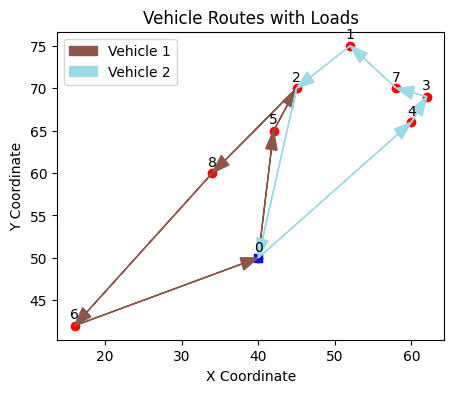

In [3]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    # create list of dynamic length, depending on len(Vehicles) with different colors
    num_vehicles = len(Vehicles)

    # Generate distinct colors using a colormap
    cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors
    colors = [cmap(i) for i in range(num_vehicles)]  # Extract `num_vehicles` colors

    for v in Vehicles:
        load = 0
        sorted_routes = sorted(routes[v], key=lambda x: service_start[x[0], v].X)
        for (i, j) in sorted_routes:
            load += q[i]*sum(z[i, v, w].X for w in range(len(time_windows[int(i)])))
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")
            mid_x = (xcoord[i] + xcoord[j]) / 2 
            mid_y = (ycoord[i] + ycoord[j]) / 2 
            # plt.text(mid_x, mid_y, f'{load}', color='black', fontsize=10, fontweight='bold', ha='center')
            print(f"Vehicle {v} is currently carrying load {load} after visiting node {i}.")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes with Loads')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")

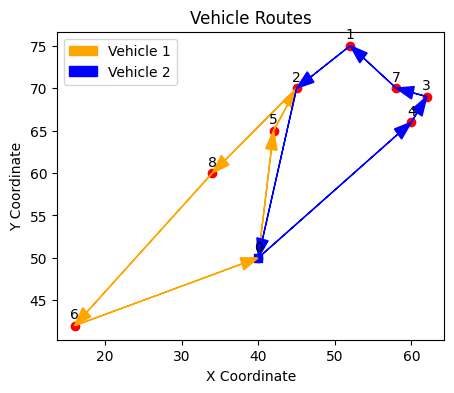

In [4]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    colors = ['green', 'orange', 'blue']  # Define colors for each vehicle
    for v in Vehicles:
        for (i, j) in routes[v]:
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")